# Convolutional neural network
### Import libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D # type: ignore
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import json
from tensorflow.keras.models import load_model # type: ignore

### Data loading 

In [2]:
df = pd.read_csv('cocomo81_preprocessed.csv')
df.describe()

,rely,data,stor,turn,aexp,pcap,lexp,modp,loc,actual
count,63.000000,63.000000,63.00000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,1.036349,1.003968,1.14381,0.971746,0.948571,0.925556,1.001429,1.004127,3.276913,4.795678
std,0.193477,0.073431,0.17942,0.080973,0.119243,0.137592,0.051988,0.130935,1.292031,1.677660
min,0.750000,0.940000,1.00000,0.870000,0.820000,0.700000,0.950000,0.820000,1.091923,1.931521
25%,0.880000,0.940000,1.00000,0.870000,0.820000,0.860000,0.950000,0.910000,2.265869,3.725621
50%,1.000000,1.000000,1.06000,1.000000,1.000000,0.860000,1.000000,1.000000,3.258097,4.595120
75%,1.150000,1.040000,1.21000,1.000000,1.000000,1.000000,1.000000,1.100000,4.110874,6.083915
max,1.400000,1.160000,1.56000,1.150000,1.290000,1.170000,1.140000,1.240000,5.764878,7.789248


### Training a Multilayer Perceptron model

In [3]:
features = ['rely', 'data', 'stor', 'turn', 'aexp', 'pcap', 'lexp', 'modp', 'loc']
target = 'actual'
X = df[features].values
y = df[target].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train size: {X_train.shape}')
print(f'X_test size: {X_val.shape}')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

X_train size: (50, 9)
X_test size: (13, 9)


In [5]:
# Build model
model = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(20, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 16)             64        
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 16)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 32)             1056      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                        

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=300,
    batch_size=8,
    callbacks=[early_stopping]
)

Epoch 1/300
7/7 [==============================] - 1s 30ms/step - loss: 28.2002 - mae: 5.0328 - val_loss: 23.3619 - val_mae: 4.5628
Epoch 2/300
7/7 [==============================] - 0s 6ms/step - loss: 25.8050 - mae: 4.7928 - val_loss: 21.8145 - val_mae: 4.3846
Epoch 3/300
7/7 [==============================] - 0s 6ms/step - loss: 24.2462 - mae: 4.6329 - val_loss: 20.5159 - val_mae: 4.2268
Epoch 4/300
7/7 [==============================] - 0s 5ms/step - loss: 22.8122 - mae: 4.4714 - val_loss: 19.0245 - val_mae: 4.0374
Epoch 5/300
7/7 [==============================] - 0s 5ms/step - loss: 21.1687 - mae: 4.2778 - val_loss: 17.2371 - val_mae: 3.7954
Epoch 6/300
7/7 [==============================] - 0s 5ms/step - loss: 18.6002 - mae: 3.9451 - val_loss: 14.9609 - val_mae: 3.4595
Epoch 7/300
7/7 [==============================] - 0s 5ms/step - loss: 15.6666 - mae: 3.5742 - val_loss: 12.2450 - val_mae: 3.0083
Epoch 8/300
7/7 [==============================] - 0s 5ms/step - loss: 12.6425 - m

### Applying PSO to optimize MLP hyperparameters
- Hyperparameters to be optimized
    - number of filters in first and second Conv1D (int)
    - number of kernel sizes in first and second Conv1D (int)
    - number of dense layers (int)
    - number of neurons in each dense layer (int)
    - dropout rate (float)
    - learning rate (float)
    - optimizer (adam, sgd, rmsprop)

In [4]:
# Define bound for each parameter
param_bounds = {         
    'filters1': (8, 32),
    'filters2': (16, 64),
    'kernels1': (2, 5),
    'kernels2': (2, 4),  
    'dense_size': (1, 3),
    'neurons': (4, 64),
    'dropout_rate': (0.1, 0.5),
    'learning_rate': (0.0001, 0.01),
}
optimizer_list = ['adam', 'rmsprop']



# Define CNN model building function
def build_cnn_model(params, optimizer_name):
    model = tf.keras.Sequential()
    model.add(Conv1D(
        filters=int(round(params['filters1'])), 
        kernel_size=int(round(params['kernels1'])), 
        activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(
        filters=int(round(params['filters2'])), 
        kernel_size=int(round(params['kernels2'])), 
        activation='relu'))
    model.add(Flatten())
    
    for _ in range(int(round(params['dense_size']))):
        model.add(tf.keras.layers.Dense(int(round(params['neurons'])), activation='relu'))

    model.add(tf.keras.layers.Dropout(params['dropout_rate']))
    model.add(tf.keras.layers.Dense(1))

    optimizer = {
        'adam': tf.keras.optimizers.Adam,
        'rmsprop': tf.keras.optimizers.RMSprop
    }[optimizer_name](learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    return model




# Define model evaluation function
def evaluate_model(params, optimizer_idx, k=5):
    optimizer = optimizer_list[int(round(optimizer_idx))]

    X_cnn = X.reshape(X.shape[0], X.shape[1], 1)
    val_scores = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X_cnn):
        X_train_v, X_val_v = X[train_index], X[val_index]
        y_train_v, y_val_v = y[train_index], y[val_index]
        
        scaler = StandardScaler()
        X_train_v = scaler.fit_transform(X_train_v)
        X_val_v = scaler.transform(X_val_v)
        
        model = build_cnn_model(params, optimizer)
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True
        )

        history = model.fit(
            X_train_v, y_train_v,
            validation_data=(X_val_v, y_val_v),
            epochs=300,
            batch_size=8,
            verbose=0,
            callbacks=[early_stopping]
        )
        val_mae = min(history.history['val_mae'])
        val_scores.append(val_mae)

    return np.mean(val_scores)





# Define particle class
class Particle:
    def __init__(self):
        self.position = {
            'filters1': np.random.randint(*param_bounds['filters1']),
            'filters2': np.random.randint(*param_bounds['filters2']),
            'kernels1': np.random.randint(*param_bounds['kernels1']),
            'kernels2': np.random.randint(*param_bounds['kernels2']),
            'dense_size': np.random.randint(*param_bounds['dense_size']),
            'neurons': np.random.randint(*param_bounds['neurons']),
            'dropout_rate': np.random.uniform(*param_bounds['dropout_rate']),
            'learning_rate': np.random.uniform(*param_bounds['learning_rate']),
            'optimizer_idx': random.randint(0, len(optimizer_list) - 1),
        }
        self.velocity = {key: 0 for key in self.position}
        self.best_position = dict(self.position)
        self.best_score = float('inf')




# Define pso function
# https://arxiv.org/pdf/2101.11944
def pso(n_particles=5, n_iterations=10, w=0.5, c1=1.9, c2=1.9):
    swarm = [Particle() for _ in range(n_particles)]
    global_best = {'score': float('inf'), 'position': None}

    for iteration in range(n_iterations):
        print(f"Iteration {iteration+1}/{n_iterations}", end=" ")
        for particle in swarm:
            score = evaluate_model(particle.position, particle.position['optimizer_idx'])

            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = dict(particle.position)

            if score < global_best['score']:
                global_best['score'] = score
                global_best['position'] = dict(particle.position)

        for particle in swarm:
            for key in particle.position:
                r1, r2 = np.random.rand(), np.random.rand()
                cognitive = c1 * r1 * (particle.best_position[key] - particle.position[key])
                social = c2 * r2 * (global_best['position'][key] - particle.position[key])
                particle.velocity[key] = w * particle.velocity[key] + cognitive + social
                particle.position[key] += particle.velocity[key]

                if key in param_bounds:
                    low, high = param_bounds[key]
                    particle.position[key] = np.clip(particle.position[key], low, high)

                elif key.endswith('_idx'):
                    particle.position[key] = int(np.clip(particle.position[key], 0, len(optimizer_list) - 1))
        print(f"MAE: {global_best['score']}")
    return global_best

In [13]:
best_result = pso(n_particles=10, n_iterations=10)
print("Best MAE:", best_result['score'])
print("Best Hyperparameters:")
for key, value in best_result['position'].items():
    if key.endswith('_idx'):
        print("optimizer:", optimizer_list[int(round(value))])
    else:
        print(f"{key}: {value}")

Iteration 1/10 MAE: 0.6449636936187744
Iteration 2/10 MAE: 0.6426934838294983
Iteration 3/10 MAE: 0.6426934838294983
Iteration 4/10 MAE: 0.619686222076416
Iteration 5/10 MAE: 0.619686222076416
Iteration 6/10 MAE: 0.619686222076416
Iteration 7/10 MAE: 0.5781024515628814
Iteration 8/10 MAE: 0.5781024515628814
Iteration 9/10 MAE: 0.5781024515628814
Iteration 10/10 MAE: 0.5781024515628814
Best MAE: 0.5781024515628814
Best Hyperparameters:
filters1: 8.0
filters2: 64.0
kernels1: 2.0
kernels2: 2.0
dense_size: 2.794590884818654
neurons: 41.442859171776036
dropout_rate: 0.21961014827280478
learning_rate: 0.0056723041860013024
optimizer: adam


In [ ]:
best_result = {}
# Load hyperparameters
with open("../cocomo81/best_cnn_hyperparams.json", "r") as f:
    best_result['position'] = json.load(f)

In [75]:
optimizer = optimizer_list[int(best_result['position']['optimizer_idx'])]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

model = build_cnn_model(best_result['position'], optimizer)
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=300,
    batch_size=8,
    callbacks=[early_stopping]
)


Epoch 1/300
7/7 [==============================] - 1s 27ms/step - loss: 18.2186 - mae: 3.8482 - val_loss: 4.3148 - val_mae: 1.6179
Epoch 2/300
7/7 [==============================] - 0s 6ms/step - loss: 4.1322 - mae: 1.6558 - val_loss: 3.2778 - val_mae: 1.4221
Epoch 3/300
7/7 [==============================] - 0s 5ms/step - loss: 3.5964 - mae: 1.5364 - val_loss: 3.7695 - val_mae: 1.3945
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 3.4668 - mae: 1.4939 - val_loss: 2.9050 - val_mae: 1.2288
Epoch 5/300
7/7 [==============================] - 0s 5ms/step - loss: 2.8116 - mae: 1.3618 - val_loss: 4.0791 - val_mae: 1.3775
Epoch 6/300
7/7 [==============================] - 0s 5ms/step - loss: 2.8537 - mae: 1.4030 - val_loss: 3.1053 - val_mae: 1.3511
Epoch 7/300
7/7 [==============================] - 0s 6ms/step - loss: 2.0666 - mae: 1.1761 - val_loss: 3.8155 - val_mae: 1.5283
Epoch 8/300
7/7 [==============================] - 0s 6ms/step - loss: 1.9398 - mae: 1.0723 - v

### Final evaluation

In [73]:
model = load_model('../cocomo81/best_cnn_model.keras')
y_pred_val_log = model.predict(X_val_cnn)

# flatten to ensure it's a 1D array
y_pred_log = y_pred_val_log.flatten()

# avoid divide by 0
y_val_nonzero_log = y_val[y_val != 0]
y_pred_nonzero_log = y_pred_log[y_val != 0]

mse = mean_squared_error(y_val, y_pred_log)
mae = mean_absolute_error(y_val, y_pred_log)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_log)

mape = np.mean(np.abs((y_val_nonzero_log - y_pred_nonzero_log) / y_val_nonzero_log))

mmre = np.mean(np.abs((y_val_nonzero_log - y_pred_nonzero_log) / y_val_nonzero_log))

mdmre = np.median(np.abs((y_val_nonzero_log - y_pred_nonzero_log) / y_val_nonzero_log))

pred_25 = np.mean(np.abs((y_val_nonzero_log - y_pred_nonzero_log) / y_val_nonzero_log) <= 0.25)

print(f"MSE         : {mse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"RMSE        : {rmse:.4f}")
print(f"R²          : {r2:.4f}")
print(f"MAPE        : {mape * 100:.2f}%")
print(f"MMRE        : {mmre:.4f}")
print(f"MdMRE       : {mdmre:.4f}")
print(f"PRED(25)    : {pred_25 * 100:.2f}%")


print()
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}
for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_val), len(y_val), replace=True)
    y_val_boot = y_val[indices]
    y_pred_boot = y_pred_log[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_val_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_val_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_val_boot, y_pred_boot))
    y_val_boot_nonzero = y_val_boot[y_val_boot != 0]
    y_pred_boot_nonzero = y_pred_boot[y_pred_boot != 0]
    bootstrap_metrics['mape'].append(np.mean(np.abs((y_val_boot_nonzero - y_pred_boot_nonzero) / y_val_boot_nonzero)))
    bootstrap_metrics['mmre'].append(np.mean(np.abs((y_val_boot_nonzero - y_pred_boot_nonzero) / y_val_boot_nonzero)))
    bootstrap_metrics['mdmre'].append(np.median(np.abs((y_val_boot_nonzero - y_pred_boot_nonzero) / y_val_boot_nonzero)))
    bootstrap_metrics['pred25'].append(np.mean(np.abs((y_val_boot_nonzero - y_pred_boot_nonzero) / y_val_boot_nonzero) <= 0.25))
    
print(f"MSE         : {np.std(bootstrap_metrics['mse']):.4f}")
print(f"MAE         : {np.std(bootstrap_metrics['mae']):.4f}")
print(f"RMSE        : {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"R²          : {np.std(bootstrap_metrics['r2']):.4f}")
print(f"MAPE        : {np.std(bootstrap_metrics['mape']) * 100:.2f}%")
print(f"MMRE        : {np.std(bootstrap_metrics['mmre']):.4f}")
print(f"MdMRE       : {np.std(bootstrap_metrics['mdmre']):.4f}")
print(f"PRED(25)    : {np.std(bootstrap_metrics['pred25'])* 100:.2f}%")

1/1 [==============================] - 0s 67ms/step
MSE         : 0.6748
MAE         : 0.6799
RMSE        : 0.8215
R²          : 0.7298
MAPE        : 17.79%
MMRE        : 0.1779
MdMRE       : 0.1232
PRED(25)    : 84.62%

MSE         : 0.2343
MAE         : 0.1307
RMSE        : 0.1436
R²          : 0.2030
MAPE        : 5.14%
MMRE        : 0.0514
MdMRE       : 0.0387
PRED(25)    : 10.01%


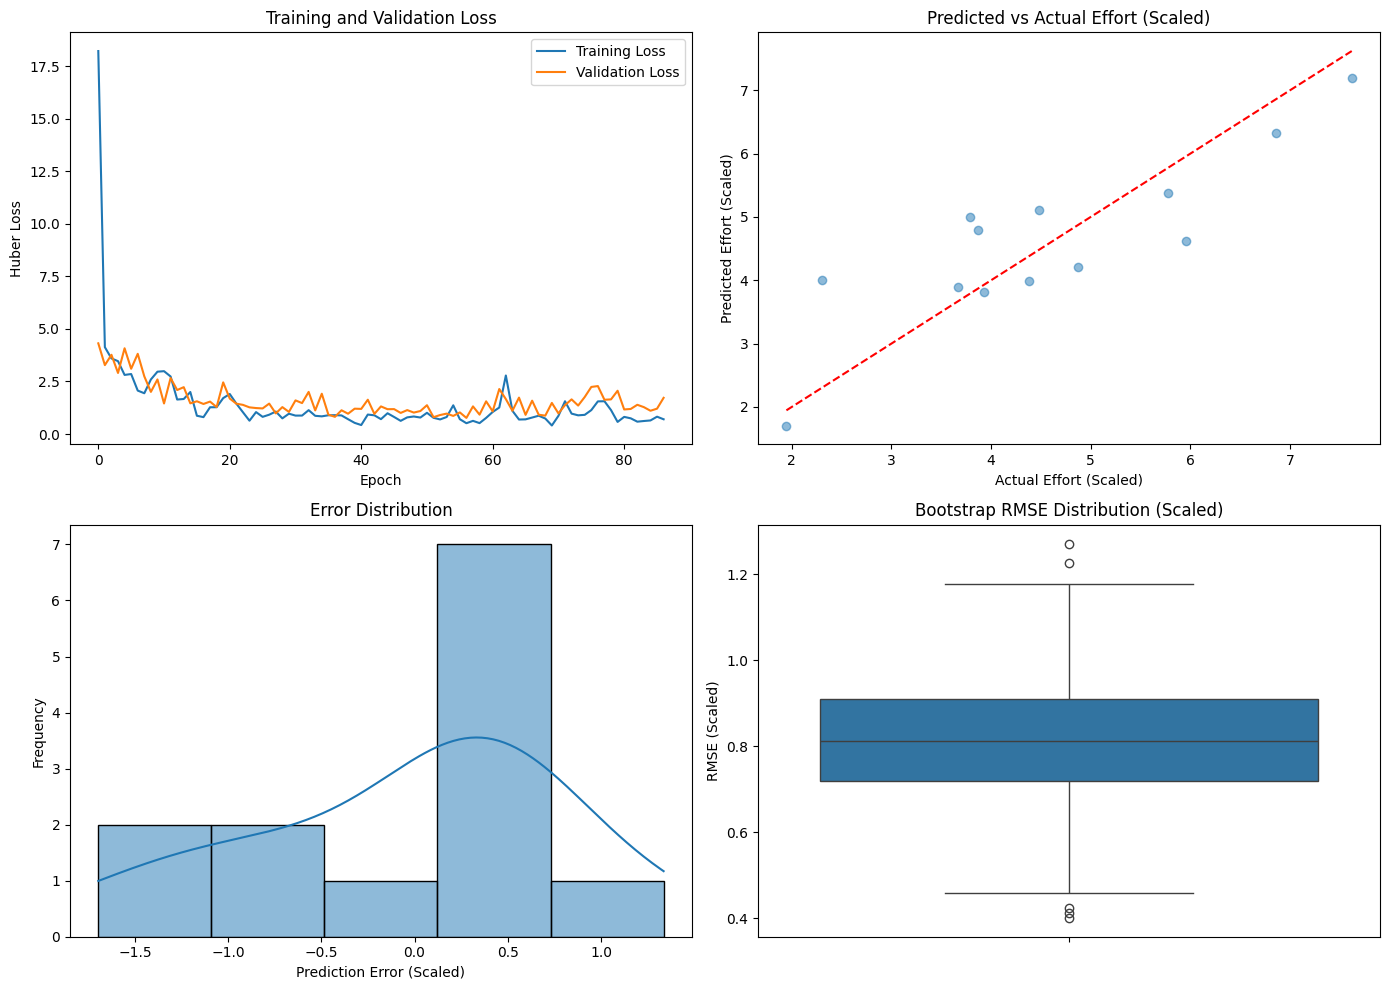

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_val, y_pred_log, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_val - y_pred_log
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.show()